# 決算発表日前後の値動きをチャート化するコード

In [2]:
import pickle
import datetime
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
from mpl_finance import candlestick2_ohlc, volume_overlay

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from tqdm.auto import tqdm

%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
warnings.simplefilter('ignore')

In [3]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# チュートリアルのtrain_X, val_X, test_X, train_y, val_y, test_y　私はpickleで保存しています
# ""の中身はご自身の環境に合わせて定義してください
train_X = pickle_load("...")
val_X = pickle_load("...")
test_X = pickle_load("...")
train_y = pickle_load("...")
val_y = pickle_load("...")
test_y = pickle_load("...")

In [5]:
# データセットの読み込み
# ""の中身はご自身の環境に合わせて定義してください
dataset_dir="..."
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

dfs = {}
for k, v in inputs.items():
    dfs[k] = pd.read_csv(v)

In [6]:
# code, start(datetime型), end(datetime型)を指定してOHLCVを取得
def get_data_for_plot(code, start, end):
    tmp_df = dfs["stock_price"].copy()
    tmp_df = tmp_df[tmp_df["Local Code"]==code]
    tmp_df["datetime"] = pd.to_datetime(tmp_df["EndOfDayQuote Date"])
    tmp_df = tmp_df.set_index("datetime")
    tmp_df = tmp_df[(tmp_df.index>=start) & (tmp_df.index<=end)]
    tmp_feat = ["EndOfDayQuote Open", "EndOfDayQuote High", "EndOfDayQuote Low", "EndOfDayQuote Close", "EndOfDayQuote Volume"]
    tmp_df = tmp_df[tmp_feat]
    tmp_df.columns = ["open", "high", "low", "close", "volume"]
    return tmp_df

In [7]:
# 8つのOHLCVチャートを描画します
def plot_ohlcv1(codes, plot_dfs):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(18,15))
    for i in range(8):
        candlestick2_ohlc(ax[int(i/2), i%2], plot_dfs[i]["open"], plot_dfs[i]["high"], plot_dfs[i]["low"], plot_dfs[i]["close"], width=0.9, colorup="b", colordown="r")
        ax[int(i/2), i%2].set_xticklabels([plot_dfs[i].index[d].strftime("%y/%m/%d") for d in range(0, len(plot_dfs[i]), 7)])
        ax[int(i/2), i%2].xaxis.set_major_locator(DayLocator(interval=7))
        ax[int(i/2), i%2].set_ylabel("price")
        bottom, top = ax[int(i/2), i%2].get_ylim()
        ax[int(i/2), i%2].set_ylim(bottom - (top - bottom) / 4, top)
        ax[int(i/2), i%2].set_title(str(codes[i]))
        ax2 = ax[int(i/2), i%2].twinx()
        volume_overlay(ax2, plot_dfs[i]["open"], plot_dfs[i]["close"], plot_dfs[i]["volume"], width=1, colorup="g", colordown="g")
        ax2.set_ylim([0, plot_dfs[i]["volume"].max() * 4])
        ax2.set_ylabel("volume")

## 20日高値　上位銘柄群

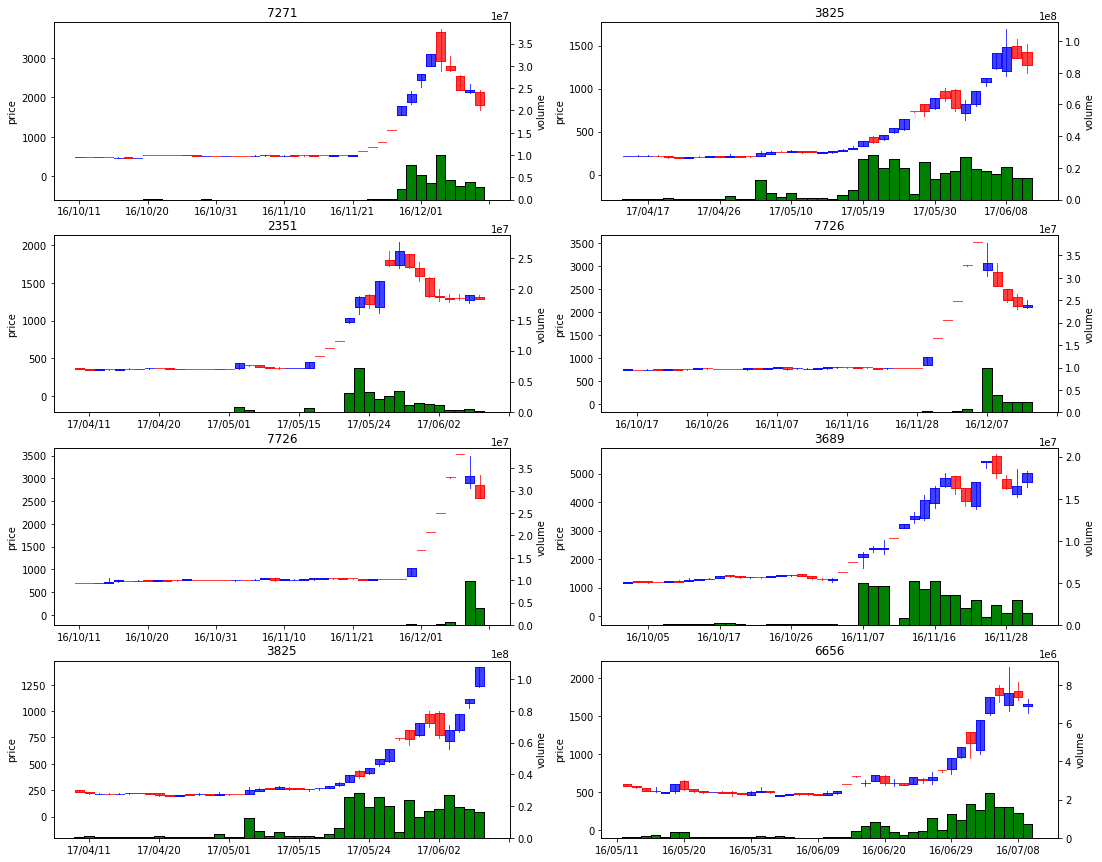

In [8]:
train_data = train_X["label_high_20"].copy()
train_data["target"] = train_y["label_high_20"]             # labelをマージ
tmp_df = train_data[train_data["return_3month"] != 0]       # 3ヶ月以前のデータがないものはいったん除外
tmp_df = tmp_df.sort_values("target", ascending=False)[:8]  # labelの上位8データを取得
codes = [tmp_df["code"].iloc[i] for i in range(len(tmp_df))]
dates = [tmp_df.index[i] for i in range(len(tmp_df))]
plot_dfs = [get_data_for_plot(codes[i], dates[i]-datetime.timedelta(30), dates[i]+datetime.timedelta(30)) for i in range(len(tmp_df))]
plot_ohlcv1(codes, plot_dfs)

## 20日安値　下位銘柄群

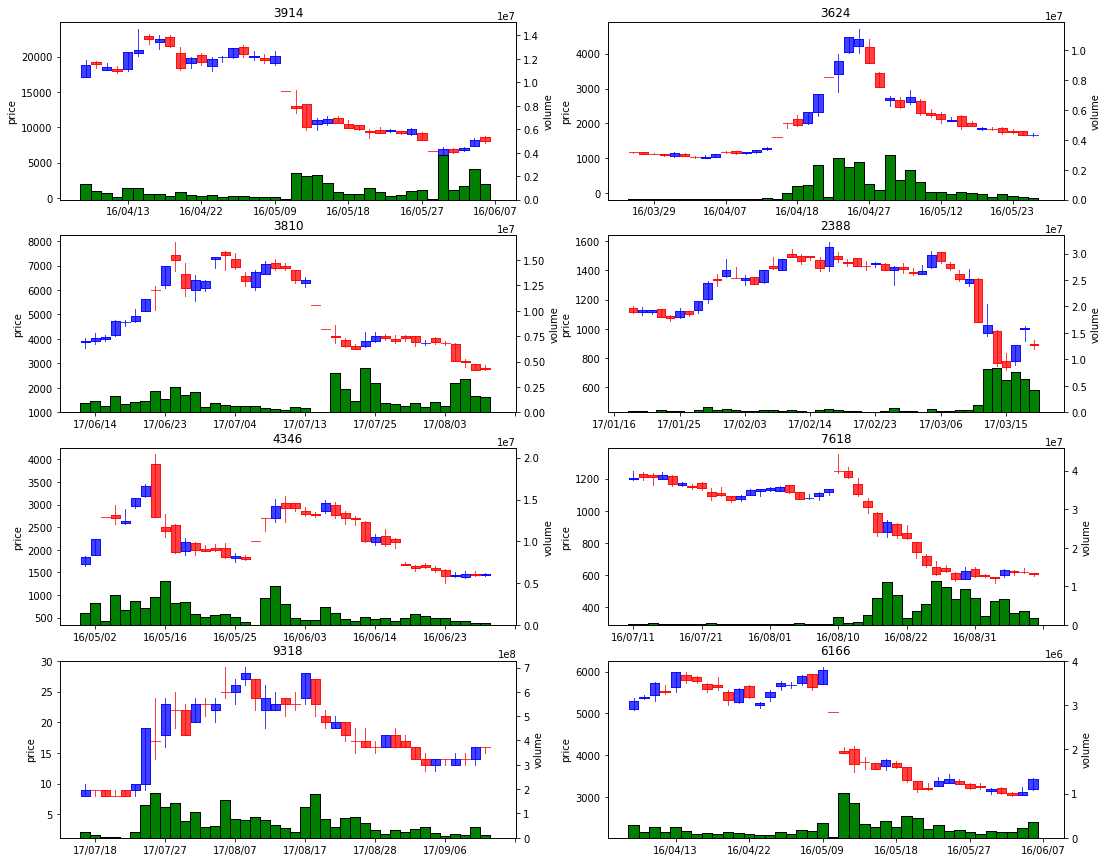

In [9]:
train_data = train_X["label_low_20"].copy()
train_data["target"] = train_y["label_low_20"]
tmp_df = train_data[train_data["return_3month"] != 0]
tmp_df = tmp_df.sort_values("target")[:8]
codes = [tmp_df["code"].iloc[i] for i in range(len(tmp_df))]
dates = [tmp_df.index[i] for i in range(len(tmp_df))]
plot_dfs = [get_data_for_plot(codes[i], dates[i]-datetime.timedelta(30), dates[i]+datetime.timedelta(30)) for i in range(len(tmp_df))]
plot_ohlcv1(codes, plot_dfs)